In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets

In [3]:
data = datasets.load_iris() # vraca objekat koji sadrzi:
# data -> NumPy niz koji sadrzi vrednosti atributa
# target -> NumPy niz koji sadrži klase
# feature_names -> Lista imena atributa

columns = np.array(data.feature_names)
print(columns)
X = data.data 
print(X.shape)
y = data.target
print(y.shape)

data_values = np.concatenate((X, y.reshape((y.shape[0], 1))), axis=1)
iris_df = pd.DataFrame(data=data_values, columns=[col for col in columns] + ['class'])

['sepal length (cm)' 'sepal width (cm)' 'petal length (cm)'
 'petal width (cm)']
(150, 4)
(150,)


I grupa: Filter metode
- ne koriste model
- gledaju samo statističke relacije između atributa i cilja
- najbrže su, ali mogu biti manje precizne.

1) Posmatranje korelacije atributa sa targetom

1.1. Pearson korelacija

In [11]:
Pearson_corr_target = iris_df.drop(columns=['class']).corrwith(iris_df['class'], method="pearson")
print(Pearson_corr_target.sort_values(ascending=False))

petal width (cm)     0.956547
petal length (cm)    0.949035
sepal length (cm)    0.782561
sepal width (cm)    -0.426658
dtype: float64


1.2. Spearman korelacija sa targetom

In [12]:
Spearman_corr_target = iris_df.drop(columns=['class']).corrwith(iris_df['class'], method="spearman")
print(Spearman_corr_target.sort_values(ascending=False))

petal width (cm)     0.938179
petal length (cm)    0.935431
sepal length (cm)    0.798078
sepal width (cm)    -0.440290
dtype: float64


2) Eliminacija atributa sa varijansom ispod zadatog praga

In [14]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0.2) # Eliminisanje attributa sa varijansom manjom od 0.2
X_vt = vt.fit_transform(X)

# Izdvajanje indeksa odabranih atributa
selected_attributes = columns[vt.get_support()]
print(selected_attributes)

['sepal length (cm)' 'petal length (cm)' 'petal width (cm)']


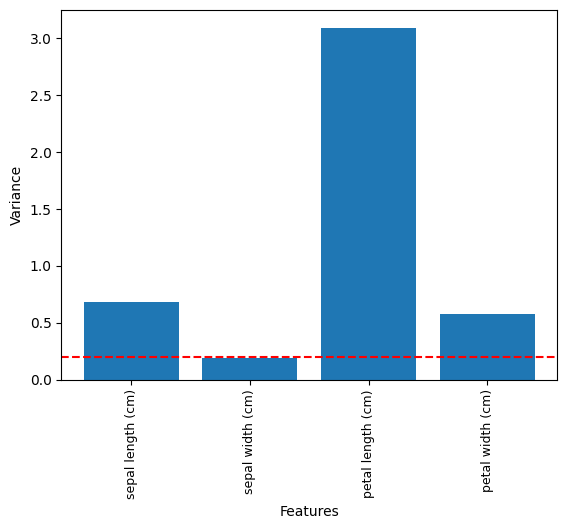

In [20]:
import matplotlib.pyplot as plt

# nema skaliranja

plt.bar(x=columns, height=X.var(axis=0))
plt.axhline(y=0.2, color='r', linestyle='--', label='Threshold = 0.2')
plt.xlabel("Features")
plt.ylabel("Variance")
plt.xticks(rotation=90,fontsize=9)
plt.show()

3) Chi-square test - meri da li je kategorijski feature statistički povezan sa target klasom koja je isto kategorička:
    - ako je p-vrednost mala (p < 0.05), feature je značajan
    - ako je velika, feature je nebitan za predikciju targeta

Chi-square poredi:
- očekivane vrednosti (sta bi target distribucija trebalo da bude ako feature i target nisu povezani)
- posmatrane vrednosti (prave frekvencije iz dataset-a)

Ako se posmatrane frekvencije mnogo razlikuju od očekivanih tada postoji povezanost i feature je dobar.

Ograničenja:
    - radi samo sa pozitivnim, neskaliranim vrednostima
    - ne radi za regresiju i nije dobar za retke kategorije 
    - svaki red u tabeli predstavlja jedan nezavisan podatak (ne sme biti time series podataka gde su susedni redovi zavisni)
    - neophodno je uraditi one-hot-encoding

4) ANOVA - F test - meri da li se srednje vrednosti feature-a znacajno razlikuju između klasa:
    - ako se razlikuju onda je feature znacajan
    - ako su vrednosti feature-a slične kroz sve klase onda nije koristan

In [22]:
from sklearn.feature_selection import f_classif

F_scores, p_values = f_classif(X, y)

anova_results = pd.DataFrame({
    "feature": columns,
    "F_score": F_scores,
    "p_value": p_values
})

anova_results = anova_results.sort_values(by="F_score", ascending=False)

print("\nANOVA F-test results:")
print(anova_results)



ANOVA F-test results:
             feature      F_score       p_value
2  petal length (cm)  1180.161182  2.856777e-91
3   petal width (cm)   960.007147  4.169446e-85
0  sepal length (cm)   119.264502  1.669669e-31
1   sepal width (cm)    49.160040  4.492017e-17


K-Best - generički selektor feature-a

In [26]:
from sklearn.feature_selection import SelectKBest
import numpy as np

selector = SelectKBest(score_func=f_classif, k=2) # moze se proslediti i korisnicki definisana funkcija
X_new = selector.fit_transform(X, y)

print("Izabrani indeksi:", selector.get_support(indices=True)) # indices=False dobija se boolean niz koje kolone se ukljucene/iskljucene
print("Izabrani feature-i:", np.array(columns)[selector.get_support()])



Izabrani indeksi: [2 3]
Izabrani feature-i: ['petal length (cm)' 'petal width (cm)']


 II grupa: Wrapper metode - koriste model i testiraju različite kombinacije atributa; tačne su, ali i spore

1) Forward Selection
    - krece se od praznog skupa atributa
    - prave se sve moguce kombinacije atributa, gde svaku kombinaciju duzine n gradimo tako sto vec imamo izabranih n-1 najboljih atributa i trazimo novi n-ti atribut koji ce poboljsati score
    - ako se sa povecanjem duzine kombinacije nije poboljsao score ili se smanjio - prekida se dalja pretraga

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def forward_selection(X, y, feature_names, model, cv=5, verbose=True):
    n_features = X.shape[1]
    remaining_features = list(range(n_features))  # indeksi
    selected_features = []
    selected_feature_names = []

    best_overall_score = 0.0

    while remaining_features:
        best_score_this_round = 0.0
        best_feature = None

        for feat in remaining_features:
            # Izaberi kandidate za ovu rundu
            candidate_features = selected_features + [feat]
            X_candidate = X[:, candidate_features]

            # Evaluiraj model
            scores = cross_val_score(model, X_candidate, y, cv=cv)
            score_mean = scores.mean()

            if verbose:
                print(f"[Forward] Trying {feature_names[feat]} with current set "
                      f"{[feature_names[i] for i in selected_features]} "
                      f"-> mean score = {score_mean:.4f}")

            # Da li se poboljsao score u ovoj rundi
            if score_mean > best_score_this_round:
                best_score_this_round = score_mean
                best_feature = feat

        # Ako nema poboljsanja - stop
        if best_feature is None or best_score_this_round <= best_overall_score:
            if verbose:
                print("No further improvement. Stopping forward selection.")
            break
        # U suprotnom se uzima i taj atribut u skup
        selected_features.append(best_feature)
        selected_feature_names.append(feature_names[best_feature])
        remaining_features.remove(best_feature)
        best_overall_score = best_score_this_round

        if verbose:
            print(f"Selected feature: {feature_names[best_feature]} "
                  f"(score = {best_overall_score:.4f})")
            print("-" * 60)

    return selected_features, selected_feature_names, best_overall_score


base_model = LogisticRegression(max_iter=1000)
fwd_indices, fwd_names, fwd_score = forward_selection(
    X, y, columns, base_model, cv=5
)

print("\nForward Selection result:")
print("Selected indices:", fwd_indices)
print("Selected features:", fwd_names)
print("Best CV score:", fwd_score)


[Forward] Trying sepal length (cm) with current set [] -> mean score = 0.7533
[Forward] Trying sepal width (cm) with current set [] -> mean score = 0.5667
[Forward] Trying petal length (cm) with current set [] -> mean score = 0.9533
[Forward] Trying petal width (cm) with current set [] -> mean score = 0.9600
Selected feature: petal width (cm) (score = 0.9600)
------------------------------------------------------------
[Forward] Trying sepal length (cm) with current set [np.str_('petal width (cm)')] -> mean score = 0.9533
[Forward] Trying sepal width (cm) with current set [np.str_('petal width (cm)')] -> mean score = 0.9400
[Forward] Trying petal length (cm) with current set [np.str_('petal width (cm)')] -> mean score = 0.9600
No further improvement. Stopping forward selection.

Forward Selection result:
Selected indices: [3]
Selected features: [np.str_('petal width (cm)')]
Best CV score: 0.96


2) Backward Elimination 

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def backward_elimination(X, y, feature_names, model, cv=5, verbose=True):
    n_features = X.shape[1]
    current_features = list(range(n_features))
    
    # Evaluiraj model sa svim ukljucenim atributima
    X_current = X[:, current_features]
    scores = cross_val_score(model, X_current, y, cv=cv)
    best_overall_score = scores.mean()

    if verbose:
        print(f"[Backward] Starting with all features, score = {best_overall_score:.4f}")

    improved = True
    while improved and len(current_features) > 1:
        improved = False
        best_score_this_round = best_overall_score
        worst_feature_to_drop = None

        for feat in current_features:
            candidate_features = [f for f in current_features if f != feat]
            X_candidate = X[:, candidate_features]

            scores = cross_val_score(model, X_candidate, y, cv=cv)
            score_mean = scores.mean()

            if verbose:
                print(f"[Backward] Removing {feature_names[feat]} -> score = {score_mean:.4f}")

            # Ako se rezultat poboljsao, trajno ukloniti taj atribut
            if score_mean >= best_score_this_round:
                best_score_this_round = score_mean
                worst_feature_to_drop = feat
                improved = True

        # Ako nadjemo atribut cije uklanjanje zadrzava/poboljsava score - izbacujemo taj atribut
        if improved and worst_feature_to_drop is not None:
            current_features.remove(worst_feature_to_drop)
            best_overall_score = best_score_this_round

            if verbose:
                print(f"Dropped feature: {feature_names[worst_feature_to_drop]} "
                      f"(new score = {best_overall_score:.4f})")
                print("-" * 60)

    selected_feature_names = [feature_names[i] for i in current_features]
    return current_features, selected_feature_names, best_overall_score

base_model = LogisticRegression(max_iter=1000)
bwd_indices, bwd_names, bwd_score = backward_elimination(
    X, y, columns, base_model, cv=5
)

print("\nBackward Elimination result:")
print("Selected indices:", bwd_indices)
print("Selected features:", bwd_names)
print("Best CV score:", bwd_score)


[Backward] Starting with all features, score = 0.9733
[Backward] Removing sepal length (cm) -> score = 0.9667
[Backward] Removing sepal width (cm) -> score = 0.9667
[Backward] Removing petal length (cm) -> score = 0.9467
[Backward] Removing petal width (cm) -> score = 0.9533

Backward Elimination result:
Selected indices: [0, 1, 2, 3]
Selected features: [np.str_('sepal length (cm)'), np.str_('sepal width (cm)'), np.str_('petal length (cm)'), np.str_('petal width (cm)')]
Best CV score: 0.9733333333333334


3) RFE – Recursive Feature Elimination (sklearn)

In [35]:
from sklearn.feature_selection import RFE

base_model = LogisticRegression(max_iter=1000)
rfe = RFE(estimator=base_model, n_features_to_select=2, step=1)

rfe.fit(X, y)

mask = rfe.support_ # vraca boolean vektor atributa koje treba uvrstiti
selected_rfe_names = columns[mask]

print("\nRFE result:")
print("Support mask:", mask)
print("Selected features:", selected_rfe_names)
print("Ranking:", rfe.ranking_) # lista koja prikazuje rangove za feature



RFE result:
Support mask: [False False  True  True]
Selected features: ['petal length (cm)' 'petal width (cm)']
Ranking: [3 2 1 1]


 III grupa: Embedded metode


Metode koje prilikom treniranja modela ujedno i računaju značajnost svakog atributa
Primeri:
- Regularizacija u linearnog regresiji: Lasso, Ridge, ElasticNet
- Logistička regresija sa regularizacijom
- Tree-based modeli koji prilikom treniranja računaju značajnost atibuta na osnovu Ginijevog indeksa, Entropije ...

Jos neke od Feature selection metoda na konkretnim primerima mogu se pogledati na https://github.com/codingnest/FeatureSelection.
